# 基于高德地图的路径规划

**项目任务**

在广州从指定地点地铁start，到终点地铁end的路径规划

**主要技术**

1. 最短路径算法
2. 图可视化
3. 爬虫


# 数据源
1. 图吧地图 https://ditie.mapbar.com/guangzhou_line/
2. 高德地图API

## 获取所有站点

In [1]:
import requests
import pandas as pd
import lxml.etree as le
import re

In [2]:
# 数据保存格式
df_dict = {'city':None, 'line':None, 'station': None, 'longitude': None, 'latitude': None}

In [3]:
# 爬虫获取地铁站数据
response = requests.get('https://ditie.mapbar.com/guangzhou_line/')
xpath = le.HTML(response.text)
line_titles = xpath.xpath('//strong[@class="bolder"]//text()')
line_titles = [x for idx, x in enumerate(line_titles) if idx !=1] # 不要广佛线
line_stations = [x.xpath('.//li//a/text()') for x in xpath.xpath('//div[@class="list_item"]')] # 不要广佛线
line_stations = [x for idx, x in enumerate(line_stations) if idx !=1]
df_dict['line'] = [x for x, y in zip(line_titles, line_stations) for _ in y ]
df_dict['station'] = [y.replace('站', '') for x in line_stations for y in x]
df_dict['type'] = ['地铁站' for x in line_stations for y in x]
df_dict['city'] = ['广州' for x in line_stations for y in x]

# 保存数据
pd.DataFrame(df_dict).to_csv('./line_data.csv', index=False)

In [4]:
# 查看爬去结果
df_line = pd.read_csv('./line_data.csv')
df_line

,city,line,station,longitude,latitude,type
0,广州,地铁APM线,林和西,NaN,NaN,地铁站
1,广州,地铁APM线,体育中心南,NaN,NaN,地铁站
2,广州,地铁APM线,天河南,NaN,NaN,地铁站
3,广州,地铁APM线,黄埔大道,NaN,NaN,地铁站
4,广州,地铁APM线,妇儿中心,NaN,NaN,地铁站
...,...,...,...,...,...,...
167,广州,地铁8号线,晓港,NaN,NaN,地铁站
168,广州,地铁8号线,昌岗,NaN,NaN,地铁站
169,广州,地铁8号线,宝岗大道,NaN,NaN,地铁站
170,广州,地铁8号线,沙园,NaN,NaN,地铁站


## 获取站点经纬度
1. 需要修正部分名称

In [5]:
# 修正数据名称（网页数据偏久，有些地点已经发生变化，高德地图数据较新）
df_line.replace('广州火车', '广州火车站', inplace=True)
df_line.replace('广州南', '广州南站', inplace=True)
df_line.replace('天河客运', '天河客运站', inplace=True)
df_line.replace('广州东', '广州东站', inplace=True)
df_line.replace('车陂南', '车陂南站', inplace=True)
df_line.replace('黄阁汽车城', '黄阁汽车城站', inplace=True)
df_line.replace('南村', '板桥', inplace=True)
df_line.replace('官堂', '员岗', inplace=True)
df_line.replace('万博', '南村万博', inplace=True)
df_line.replace('钟屏路', '谢村', inplace=True)
df_line.replace('海心沙', '海心沙站', inplace=True)

In [6]:
# 使用高德地图API获得站点经纬度
def get_lon_lat(city, station):
    key = '6bf16587d81d190a4fb2290cc000208e'
    url_base = 'http://restapi.amap.com/v3/geocode/geo?address={}&city={}&output=JSON&key={}'.format
    extracter = re.compile('location":"(.*?),(.*?)",')
    result = extracter.findall(requests.get(url_base(station, city, key)).text)
    if result == []:
        return [(0.0, 0.0)]
    else:
        return result

In [7]:
# 填充数据表
lon = []
lat = []
for city, station in zip(df_line['city'], df_line['station']):
    location = get_lon_lat(city, station+'地铁站')[0]
    lon.append(float(location[0]))
    lat.append(float(location[1]))

df_line['longitude'] = lon
df_line['latitude'] = lat

In [8]:
df_line

,city,line,station,longitude,latitude,type
0,广州,地铁APM线,林和西,113.323947,23.141525,地铁站
1,广州,地铁APM线,体育中心南,113.324309,23.134281,地铁站
2,广州,地铁APM线,天河南,113.324479,23.131384,地铁站
3,广州,地铁APM线,黄埔大道,113.324490,23.127054,地铁站
4,广州,地铁APM线,妇儿中心,113.324558,23.122553,地铁站
...,...,...,...,...,...,...
167,广州,地铁8号线,晓港,113.281883,23.093066,地铁站
168,广州,地铁8号线,昌岗,113.276885,23.090654,地铁站
169,广州,地铁8号线,宝岗大道,113.269700,23.086027,地铁站
170,广州,地铁8号线,沙园,113.259726,23.089011,地铁站


In [9]:
# 修正数据经纬度
def modify(station, lon, lat):
    lon_val = df_line[df_line['station'] == station]['longitude'].values
    lat_val = df_line[df_line['station'] == station]['latitude'].values
    df_line.replace(lon_val, float(lon), inplace=True)
    df_line.replace(lat_val, float(lat), inplace=True)

In [10]:
modify('广州南站', 113.269081,22.988368)
modify('会江', 113.286394,23.013047)
modify('南浦', 113.293154,23.032929)
modify('黄阁', 113.518768,22.824736)
modify('科韵路', 113.377215,23.11928)
modify('大沙东', 113.458515,23.106216)
modify('高塘石', 113.410406,23.191025)
modify('暹岗', 113.460177,23.172296)

In [11]:
# 保存数据
df_line.to_csv('./line_data2', index=False)

In [12]:
df_line

,city,line,station,longitude,latitude,type
0,广州,地铁APM线,林和西,113.323947,23.141525,地铁站
1,广州,地铁APM线,体育中心南,113.324309,23.134281,地铁站
2,广州,地铁APM线,天河南,113.324479,23.131384,地铁站
3,广州,地铁APM线,黄埔大道,113.324490,23.127054,地铁站
4,广州,地铁APM线,妇儿中心,113.324558,23.122553,地铁站
...,...,...,...,...,...,...
167,广州,地铁8号线,晓港,113.281883,23.093066,地铁站
168,广州,地铁8号线,昌岗,113.276885,23.090654,地铁站
169,广州,地铁8号线,宝岗大道,113.269700,23.086027,地铁站
170,广州,地铁8号线,沙园,113.259726,23.089011,地铁站


# 构建图

## 创建图

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# 创建图
subway = nx.Graph()

# 增加带属性节点
subway.add_nodes_from(df_line['station'].unique().tolist())
for station, line, lon, lat in zip(df_line['station'], df_line['line'], df_line['longitude'], df_line['latitude']):
    subway.nodes[station]['location'] = (lon, lat)
    if 'line' in subway.nodes[station]:
        subway.nodes[station]['line'] += [line]
    else:
        subway.nodes[station]['line'] = [line]
        
# 增加带属性边
subway.add_edges_from([(s1, s2) for l, x in df_line.groupby('line') for s1, s2 in zip(x['station'][:-1], x['station'][1:])])
for l, x in df_line.groupby('line'):
    for s1, s2 in zip(x['station'][:-1], x['station'][1:]):
        subway[s1][s2]['line'] = l


## 可视化图

In [15]:
from collections import defaultdict
import math

In [16]:
# 经纬度转直角坐标系
def millerToXY(data_tuple):
    lon = data_tuple[0]
    lat = data_tuple[1]
    L = 6381372*math.pi*2    #地球周长
    W = L                    #平面展开，将周长视为X轴
    H = L/2                  #Y轴约等于周长一般
    mill = 2.3               #米勒投影中的一个常数，范围大约在正负2.3之间  
    x = lon*math.pi/180      #将经度从度数转换为弧度
    y = lat*math.pi/180      # 将纬度从度数转换为弧度 
    y = 1.25*math.log(math.tan(0.25*math.pi+0.4*y))  #这里是米勒投影的转换 
    
    # 这里将弧度转为实际距离 ，转换结果的单位是公里
    x = (W/2)+(W/(2*math.pi))*x
    y = (H/2)-(H/(2*mill))*y
    return (int(round(x)),-1*int(round(y)))

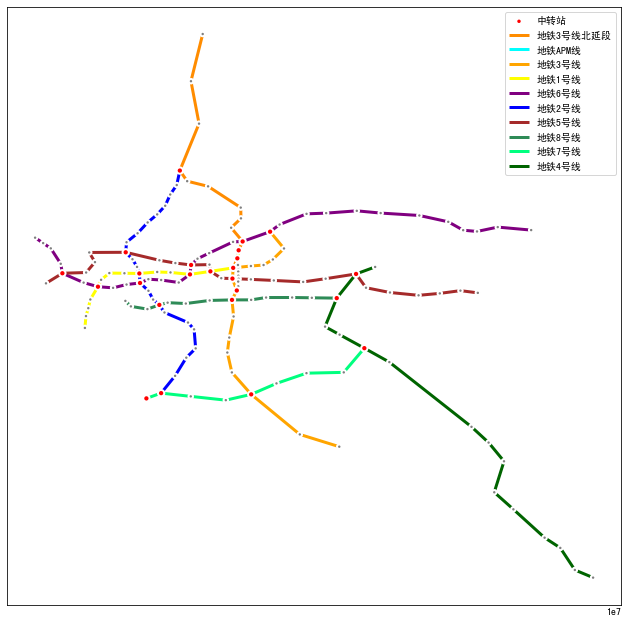

In [17]:
def plot_map(graph):

    # 绘制画布
    plt.figure(figsize=(11,11))
    
    # 默认路线颜色
    color = {'地铁APM线': 'cyan', '地铁广佛线': 'lime', '地铁1号线': 'yellow', '地铁2号线': 'b', '地铁3号线': 'orange',
             '地铁3号线北延段': 'darkorange','地铁4号线': 'darkgreen','地铁5号线': 'brown', '地铁6号线': 'purple',
             '地铁7号线': 'springgreen', '地铁8号线': 'seagreen','步行线路': 'r', '临时边': 'r'} 
    
    # 绘制节点，并获得图例handles
    positions = {x[0]: np.array(millerToXY(x[1]['location'])) for x in graph.nodes.data()}
    node_color = ['r' if (len(x[1]['line'])>1) else 'grey' for x in graph.nodes.data()]
    node_size = [40 if (len(x[1]['line'])>1) else 20 for x in graph.nodes.data()]
    h_node = nx.draw_networkx_nodes(
        graph, positions, node_size=node_size, alpha=1, node_color=node_color, edgecolors='white', linewidths=2) 
   
    # 绘制边，并获得图例handles
    line_dict = defaultdict(list)
    for i, j, x in graph.edges.data():
        line_dict[x['line']] += [(i, j)]
        
    line_legend = {}
    for line in line_dict:
        # 绘制一条line并输出handles给legend用
        temp = nx.draw_networkx_edges(graph, positions, edgelist=line_dict[line], edge_size=5, alpha=1, edge_color=color[line], width=3.0)
        line_legend[temp] = line
    
    # 画图并绘制图例
    plt.legend([h_node]+[x for x in line_legend],  ['中转站']+[x for x in list(line_legend.values())], loc='best')
    plt.show()


plot_map(subway)

# 路径搜索
1. 输入开始和结束的地铁站，找到时间或者路程最短的线路
2. 采用 Dijkstra 算法

## 获取所有边的距离
保存在图的边属性里

In [18]:
# 固定参数
key = '6bf16587d81d190a4fb2290cc000208e'
url_d = 'https://restapi.amap.com/v3/distance?origins={},{}&destination={},{}&output=xml&key={}&type=1'.format

# 对所有边获取距离
for node1, node2 in subway.edges:
    start_lon, start_lat = subway.nodes[node1]['location']
    end_lon, end_lat = subway.nodes[node2]['location']
    response = requests.get(url_d(start_lon, start_lat, end_lon, end_lat, key)).text
    subway[node1][node2]['distance'] = float(re.findall('<distance>(\d+)</distance>', response)[0])
    subway[node1][node2]['duration'] = float(re.findall('<duration>(\d+)</duration>', response)[0])

## Dijkstra 算法
1. s集合保存到每个节点最短
2. u集合保存待更新节点
3. 每次从从u提取最小的节点，与它周围的节点更新u中其他节点的最小
4. 更新u时要看节点是否已经更新过，要保证最小
5. u集合为空时候结束

In [19]:
def dijkstra(graph, start, end, strategy='distance'):

    # 初始化s
    s = {start: {'value':0, 'path': None}} 
    
    # 初始化u
    u = {node: {'value': float('inf'), 'path': []} for node in [x for x in graph.nodes if x != start]}
    for neighbor in graph[start]:
        u[neighbor]['value'] = graph[start][neighbor][strategy]
        u[neighbor]['path'].extend([start, neighbor])
    
    # 当u集合中长度为0的时候跳出循环
    while len(u.keys()) > 0:
        
        # 打擂法获取u中value最小的节点
        update = {'node': None, 'value': float('inf')}
        for node in u:
            if u[node]['value'] < update['value']:
                update['node'] = node
                update['value'] = u[node]['value']

        # 查找update的node的邻居，并更新u
        current_node = update['node']
        current_node_dict = u.pop(current_node) # 删除u中现在最小的节点并提取出值        
        sub = [x for x in graph[current_node] if x not in s] # 在s中固定了的节点不用计算        
        for node in sub:
            
            # 第一个if先查看有些节点是不是已经有更新过，如果不等于无穷大，代表之前有更新过
            if u[node]['value'] != float('inf'):
                
                # 保证在当前更新的node边比之前更新时候要短才更新u中的值
                if current_node_dict['value'] + graph[current_node][node][strategy] > u[node]['value']:
                    continue
            
            u[node]['value'] = current_node_dict['value'] + graph[current_node][node][strategy]
            u[node]['path'] = current_node_dict['path'] + [node]
    
        # update的node更新到s中
        s.update({current_node:  current_node_dict})

    return s[end]

## 搜索结果可视化

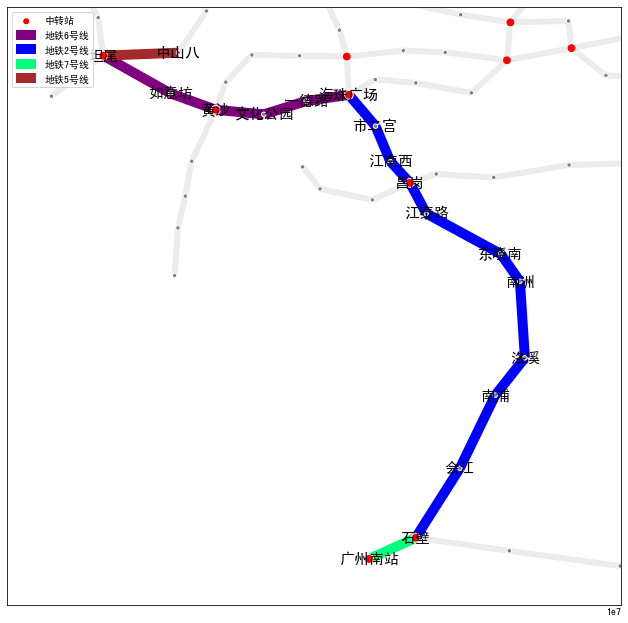

In [20]:
def plot_path(graph, path):
    
    # 绘制画布
    plt.figure(figsize=(11,11))
    
    # 默认线路颜色
    color = {'地铁APM线': 'cyan', '地铁广佛线': 'lime', '地铁1号线': 'yellow', '地铁2号线': 'b', '地铁3号线': 'orange',
             '地铁3号线北延段': 'darkorange','地铁4号线': 'darkgreen','地铁5号线': 'brown', '地铁6号线': 'purple',
             '地铁7号线': 'springgreen', '地铁8号线': 'seagreen', '步行线路': 'r', '临时边': 'r'} 
    
    # 图缩放（保持1:1图片）
    nodes_lon = [graph.nodes[x]['location'][0] for x in path]
    nodes_lat = [graph.nodes[x]['location'][1] for x in path]

    # 根据坐标轴长度计算和固定x和y轴范围
    max_lon, min_lon, max_lat, min_lat = max(nodes_lon), min(nodes_lon), max(nodes_lat), min(nodes_lat)
    (x_max, y_max), (x_min, y_min) = millerToXY((max_lon, max_lat)), millerToXY((min_lon, min_lat))
    x_mid, y_mid = (x_max + x_min) / 2, (y_max + y_min) / 2
    temp_mid = max((x_max - x_min) / 2,(y_max - y_min) / 2)+1000
    
    plt.xlim(x_mid-temp_mid, x_mid+temp_mid)
    plt.ylim(y_mid-temp_mid, y_mid+temp_mid)
  
    # 绘制节点，并获得图例handles
    positions = {x[0]: np.array(millerToXY(x[1]['location'])) for x in graph.nodes.data()}
    node_color = ['r' if (len(x[1]['line'])>1) else 'grey' for x in graph.nodes.data()]
    node_size = [80 if (len(x[1]['line'])>1) else 20 for x in graph.nodes.data()]
    
    h_node = nx.draw_networkx_nodes(
        graph, positions, node_size=node_size, alpha=1, node_color=node_color, edgecolors='white')
    
    # 绘制节点标签（设定节点是否显示名字）
    labels={x: (x if x in path else '') for x in graph.nodes}
    nx.draw_networkx_labels(graph, positions, labels=labels, font_size=15)
    
    # 绘制path的边
    path_edge_list = [x for x in graph.edges() if (x[0] in path and x[1] in path)]
    path_edge_color = [color[graph[x[0]][x[1]]['line']] for x in path_edge_list]
    
    # 绘制边，并获得图例handles
    line_dict = defaultdict(list)
    for i, j in path_edge_list:
        line_dict[graph[i][j]['line']] += [(i, j)]
        
    line_legend = {}
    for line in line_dict:
    # 绘制一条line并输出handles给legend用
        temp = nx.draw_networkx_edges(
            graph, positions, edgelist=line_dict[line], edge_size=5, alpha=1, edge_color=color[line], width=10)
        line_legend[temp] = line    
    
    # 绘制其他边
    other_edge_list = [x for x in graph.edges() if not (x[0] in path and x[1] in path)]
    nx.draw_networkx_edges(
        graph, positions, edgelist=other_edge_list, edge_size=5, alpha=0.15, edge_color='grey', width=6)
    
    # 画图
    plt.legend([h_node]+[x for x in line_legend], ['中转站']+[x for x in list(line_legend.values())], loc='best')
    plt.show()

path = dijkstra(subway, '广州南站', '中山八', strategy='distance')['path']
plot_path(subway, path)

# 用户交互
1. 根据地点查找路线
2. 开始和结束地点并不一定是地铁站

In [21]:
# 找附近站点
def find_nearby_station(graph, city, station):
     
    # API 获取经纬度
    sta_lon, sta_lat = get_lon_lat(city, station)[0]
    sta_lon, sta_lat = float(sta_lon), float(sta_lat)
    
    # 循环计算距离最小的点
    station = ''
    min_distance = float('inf')
    for node in graph.nodes.data():
        target_lon, target_lat = node[1]['location']
        distance = (sta_lon - target_lon)**2 + (sta_lat - target_lat)**2
        if min_distance > (sta_lon - target_lon)**2 + (sta_lat - target_lat)**2:
            station = node[0]
            min_distance = distance
    
    return {'station': station, 'current_lon_lat': (sta_lon, sta_lat)}

In [22]:
# 寻找路径的服务
def get_path_guide(start, end, strategy, graph):

    # 如果是新站点保存经纬度做可视化
    new_graph = graph.copy()
    
    # 判断位置是否在地图中
    for i in [start, end]:
        
        # 如果不在，往临时图里添加信息
        if i not in graph.nodes():
            result = find_nearby_station(graph, '广州', i)
            old_node = result['station']

            # 新增节点与边信息到图中
            new_graph.add_edge(i, old_node)
            new_graph.edges[(i, old_node)]['line'] = '步行线路'
            new_graph.edges[(i, old_node)]['distance'] = 0  # 简化操作
            new_graph.edges[(i, old_node)]['duration'] = 0  # 简化操作
            new_graph.nodes[i]['location'] = result['current_lon_lat']
            new_graph.nodes[i]['line'] = ['临时节点']

    path = dijkstra(new_graph, start, end, strategy=strategy)['path']
    plot_path(new_graph, path)

In [23]:
# 最终执行函数
def run():
    num = 1
    while num != 0:
        print('广州欢迎你，请选择你需要的服务') 
        print('---------------------')
        print('1 --> 查看地铁线路')
        print('2 --> 搜索路线')
        print('0 --> 退出服务')
        num = int(input('请输入序号'))
        
        if num == 1:
            plot_map(subway)
        
        elif num == 2:
            start = input('请输入你的位置：')
            end = input('请输入你的目的地：')
            print('请输入方式，1为最短路程，2为最短时间（输入错误默认最短路程最短）')
            strategy = int(input())
            if strategy == 2:
                strategy = 'duration'
            else:
                strategy = 'distance'
            get_path_guide(start, end, strategy, subway)
            
        elif num == 0:
            print('---------------------')
            print('欢迎再次使用')
            break
        
        else:
            print('输入有误，请重新输入')

# 程序运行
1. 展示简单交互过程
2. 展示查看地铁线路
3. 展示搜索节点不在地铁线路上的情况
4. 展示统一起始和终点，但是不同需求（路程优先或时间优先）的不同方案

广州欢迎你，请选择你需要的服务
---------------------
1 --> 查看地铁线路
2 --> 搜索路线
0 --> 退出服务
请输入序号1


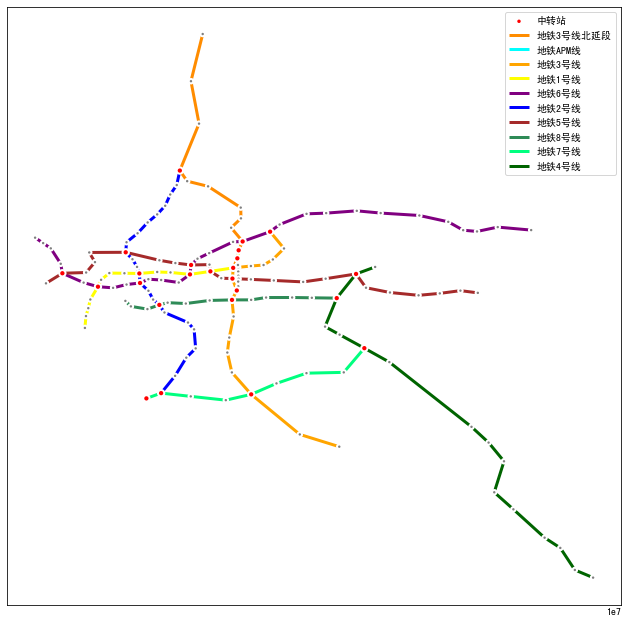

广州欢迎你，请选择你需要的服务
---------------------
1 --> 查看地铁线路
2 --> 搜索路线
0 --> 退出服务
请输入序号2
请输入你的位置：阳光酒店
请输入你的目的地：江夏
请输入方式，1为最短路程，2为最短时间（输入错误默认最短路程最短）
1


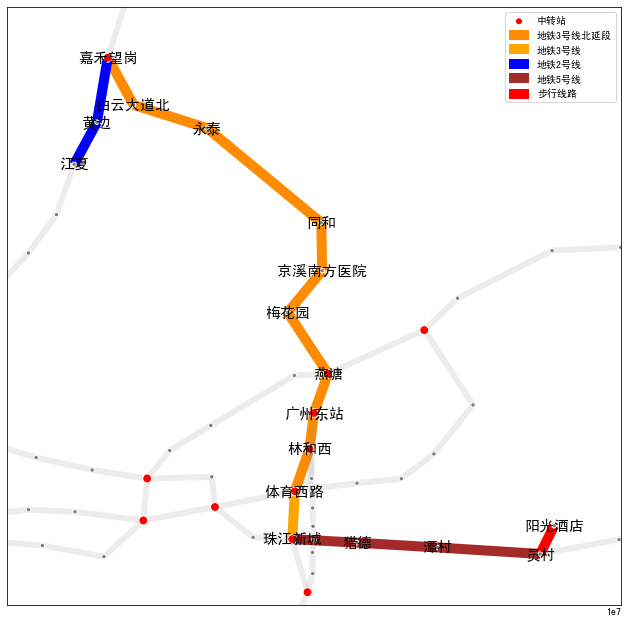

广州欢迎你，请选择你需要的服务
---------------------
1 --> 查看地铁线路
2 --> 搜索路线
0 --> 退出服务
请输入序号2
请输入你的位置：阳光酒店
请输入你的目的地：江夏
请输入方式，1为最短路程，2为最短时间（输入错误默认最短路程最短）
2


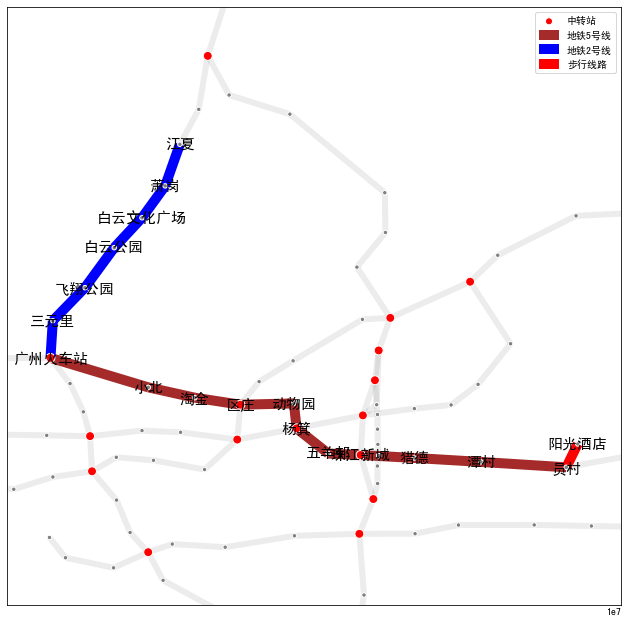

广州欢迎你，请选择你需要的服务
---------------------
1 --> 查看地铁线路
2 --> 搜索路线
0 --> 退出服务
请输入序号0
---------------------
欢迎再次使用


In [24]:
run()